In [1]:
from pathlib import Path
import sys

sys.path.append(str(Path("..").resolve()))

In [2]:
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from wheat.dataset import WheatDataset, get_train_transforms
from wheat.model import get_train_efficientdet
from effdet.data.loader import DetectionFastCollate, PrefetchLoader

OFFSET = np.asarray([0.485, 0.456, 0.406])[:, np.newaxis, np.newaxis]
SCALE = np.asarray([0.229, 0.224, 0.225])[:, np.newaxis, np.newaxis]

In [3]:
df = pd.read_csv("../data/384/train.csv")
bboxes = np.stack(df["bbox"].apply(lambda x: np.fromstring(x[1:-1], sep=",")))
for i, col in enumerate(["x", "y", "w", "h"]):
    df[col] = bboxes[:, i]
df["x2"] = df["x"] + df["w"]
df["y2"] = df["y"] + df["h"]
train_dataset = WheatDataset(
    df=df, image_dir="../data/384/train/", transforms=get_train_transforms()
)

In [8]:
dataloader = PrefetchLoader(DataLoader(
    train_dataset,
    batch_size=4,
    pin_memory=False,
    shuffle=False,
    collate_fn=DetectionFastCollate(anchor_labeler=None),
    num_workers=2,
))
batch, target = next(iter(dataloader))

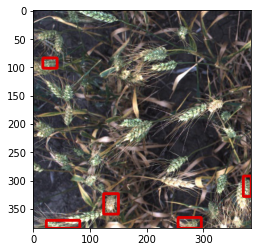

In [9]:
IDX = 1
img = ((batch[IDX].cpu().numpy() * SCALE + OFFSET).transpose(1,2,0) * 255.).astype(np.uint8).copy()
for i in range(5):
    box = target["bbox"][IDX, i, :4] 
    _ = cv2.rectangle(
        img,
        (box[0], box[1]),
        (box[2], box[3]),
        (220, 0, 0), 3)
plt.imshow(img)